<a href="https://colab.research.google.com/github/Poohi5/cmpe258_homework/blob/master/Graded_assignment2/autodiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Simple Autograd**

Q. Do  mnist classifier in colab

Reference [link text](https://github.com/joelgrus/autograd/blob/part02/autograd/tensor.py)

In [0]:
import numpy as np

In [0]:
class Tensor:

            def __init__(self, data, grad_req=False):
                self.data = data
                if not isinstance(data, np.ndarray):
                    self.data = np.array(data)
                #defined so as whether to do backprop or not?
                self.grad_req = grad_req
                # tensor gradient
                self._grad = None
                # whether this tensor was used in it
                self._grad_fn = None

            @property
            def shape(self):
                return self.data.shape

            @property
            def grad_fn(self):
                if not self.grad_req:
                    raise Exception('Tensor not backpropagated')
                return self._grad_fn

            @property
            def grad(self):
                return self._grad

            def backward(self, grad=None):
                if not self.grad_fn:
                    return False

                if grad is None and self._grad is None:
                    # in case if this is last loss tensor
                    grad = self.__class__(1., grad_req=False)

                elif self.grad is not None:
                    grad = self._grad

                if not self.grad_req:
                    raise Exception('Tensor not backpropagated')

                self.grad_fn.backward(grad)
                return True

            def __str__(self):
                return f'Tensor({str(self.data)})'

            def add_grad(self, grad):
                if self._grad is None:
                    self._grad = grad
                else:
                    self._grad += grad

            def __add__(self, o): 
                if self.data is not None:
                    self.data += o.data  
                    return self
                self.data = o.data 
                return self



Defining forward, backward calls 

In [0]:
class calls:
  def forward(self):
    raise NotImplemented

  def backward(self, grad):
    raise NotImplemented

  def __call__(self, *args):
    self.out = self.forward(*args)
    self.out._grad_fn = self
    return self.out

Addition with 2 tensors

In [0]:
class Addtion(calls):
  def forward(self, x: Tensor, y: Tensor):
    self.x = x
    self.y = y
    grad_req = x.grad_req or y.grad_req  #here the created tensor should be backprop if at least one of the input is backprop
    return Tensor(x.data + y.data, grad_req=grad_req) 

  def backward(self, grad):
    if self.x.grad_req:
      if self.x.shape != grad.shape:
        axis = np.argmax(np.abs(np.array(self.x.shape) - np.array(grad.shape)))
        self.x.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
      else:
        self.x.add_grad(grad)
      if self.x.grad_fn:
        self.x.backward()
    if self.y.grad_req:
      if self.y.shape != grad.shape:
        axis = np.argmax(np.abs(np.array(self.y.shape) - np.array(grad.shape)))
        self.x.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
      else:
        self.y.add_grad(grad)
      if self.y.grad_fn:
        self.y.backward()



Multiplication 2 tensors

In [0]:
class Mul(calls):
  def forward(self, x: Tensor, y: Tensor):
    self.x = x
    self.y = y
    grad_req = x.grad_req or y.grad_req
    return Tensor(x.data * y.data, grad_req=grad_req)

  def backward(self, grad):
    if self.x.grad_req:
      print(self.x, self.x._grad, grad)
      self.x.add_grad(Tensor(grad.data * self.y.data, False))
      if self.x.grad_fn:
        self.x.backward()
    if self.y.grad_req:
      self.y.add_grad(Tensor(grad.data * self.x.data, False))
      if self.y.grad_fn:
        self.y.backward()




##**Mnist Classfication**

Defining/Creating Neural Network

1. Create layers

In [0]:
class Layer:
  def forward(self):
    raise NotImplemented
  
  def backward(self, grad):
    raise NotImplemented

  def __call__(self, *args):
    return self.forward(*args)

2. Define activation function

In [0]:
class Sigmoid:
  def forward(self,x):
    self.x = x   
    return 1/(1+np.exp(-x))
              
  def backward(self, grad):
    grad_input = self.x*(1-self.x) * grad
    return grad_input

In [0]:
class Relu(Layer):
  def forward(self,x):
    self.x = x
    return np.maximum(np.zeros_like(x), x)
              
  def backward(self, grad):
    grad_input = (self.x > 0) * grad
    return grad_input

In [0]:
class Softmaxwithcrossentropy(Layer):
  def forward(self, x, y):
    self.x = x
    self.y = y
    
    exps = np.exp(x)
    #exps = np.exp(X - np.max(X))
    self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)
    m = self.softmax[np.arange(x.shape[0]),y]
    log_likelihood = -np.log(m)
    loss = np.sum(log_likelihood) / x.shape[0]
    return loss

    #m = y.shape[0]
    #p = softmax(X)
    # We use multidimensional array indexing to extract 
    # softmax probability of the correct label for each sample.
    # Refer to https://docs.scipy.org/doc/numpy/user/basics.indexing.html#indexing-multi-dimensional-arrays for understanding multidimensional array indexing.
    #log_likelihood = -np.log(p[range(m),y])
    #loss = np.sum(log_likelihood) / m
    #return loss
  
  def backward(self, grad=None):
    batch = self.x.shape[0]
    grad = self.softmax
    grad[np.arange(batch),self.y] -= 1
    grad = grad/batch
    return grad
  
  


3. Measure Error

In [0]:
class MeanSqError(Layer):
  def forward(self, x, y):
    self.x = x
    self.y = y
    return ((x - y)**2) / (self.x.shape[0]*2)
  
  def backward(self, grad=None):
    return (self.x - self.y) / self.x.shape[0]


4. Create Linear NN

In [0]:
class LinearNN(Layer):
  def __init__(self, input, output, alpha=0.0001): #alpha = learning rate
    self.A = 2*np.random.random((input, output)) - 1
    self.b = 2*np.random.random((output)) - 1
    self.alpha = alpha

  def forward(self, x):
    self.x = x
    return np.dot(x,self.A) + self.b

  def backward(self, grad):
    b_grad = grad.mean(axis=0)*self.x.shape[0]
    A_grad = np.dot(self.x.T, grad)
    grad_input = np.dot(grad, self.A.T)
    self.A -= A_grad * self.alpha
    self.b -= b_grad * self.alpha
    return grad_input

5. Classifying the Mnist dataset

In [0]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

In [0]:
class Model(Layer):
  def __init__(self, alpha=0.00001):
    self.alpha = alpha
    self.layers = [LinearNN(784,100, alpha=self.alpha),Relu(),LinearNN(100,200, alpha=self.alpha),Relu(),LinearNN(200,10, alpha=self.alpha)]
  
  def forward(self,x):
    for layer1 in self.layers:
      x = layer1(x)
    return x
  
  def backward(self, grad):
    for layer1 in self.layers[::-1]:
      grad = layer1.backward(grad)
    return grad
                      
                      
                          
                  

5. Use the Model built above and load the MNIST dataset from torch

In [14]:
t = transforms.Compose([transforms.ToTensor(),])
ds = MNIST('./mnist', download=True, transform=t)
data = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True)
mnist = Model()
loss = Softmaxwithcrossentropy()
_loss_avg = 0 
for e in range(5):
  for i, (img, label) in enumerate(data):
    x = img.view(2,-1).numpy()

    res = mnist(x)
    _loss = loss(res, label.numpy())
    _loss_avg += _loss.mean()
    grad = loss.backward(1)
    mnist.backward(grad)

    if i % 100 == 0:
      print(_loss_avg/100)
      _loss_avg = 0
      print('---------')


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!
1.6852803769721156
---------
110.26240582434833
---------
102.70905934647855
---------
95.67834392311924
---------
97.07245567559144
---------
85.47316941650114
---------
86.41693386070533
---------
89.85572934322188
---------
76.2020445065717
---------
85.18800706968484
---------
77.5635991377592
---------
78.6270951742617
---------
70.45589606398822
---------
82.92023349457737
---------
75.69625354315606
---------
73.66752323026748
---------
75.2194894438183
---------
71.31716081746681
---------
66.2953939439722
---------
63.87736646407605
---------
74.49054916617028
---------
62.43354796648291
---------
67.11539723446528
---------
64.46383990074781
---------
70.96199160330735
---------
65.36132619615837
---------
57.50654947755615
---------
54.07728809470665
---------
65.82162368897744
---------
57.120976184537724
---------
54.868899425578256
---------
50.59858876606576
---------
52.67008

In [0]:
import matplotlib.pyplot as plt

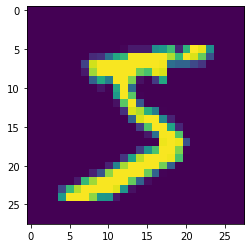

target: 5 predicted: 3


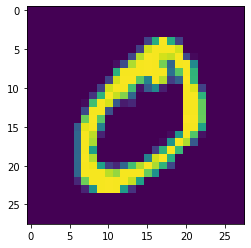

target: 0 predicted: 0


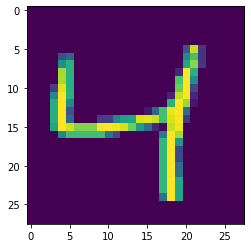

target: 4 predicted: 4


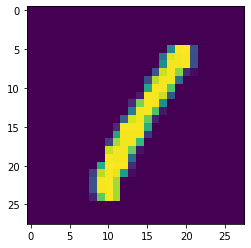

target: 1 predicted: 1


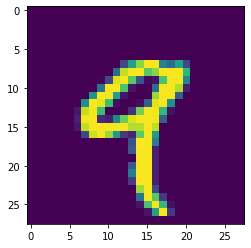

target: 9 predicted: 9


In [16]:
for i in range(5):
  img, target = ds[i]
  plt.imshow(img[0])
  plt.show()
  x = img.view(1,-1).numpy()
  res = mnist(x)[0]
  pred = np.argmax(res)
  print(f'target: {target} predicted: {pred}' )